# Digit Classification using neural networks 

In [167]:
import os
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

Reading the data


In [168]:
def load_data( data_path ):
    '''
    Loads the data from the specified path.
    
    Inputs:
    data_path: path to the directory containing the data files, each file containing measurement of a digit
    in a N x 3 matrix. 
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit.
    labels: a list of labels corresponding to the data.
    '''
    files = os.scandir( data_path )

    data = []
    labels = []
    for file in files:
        filename = file.name
        if filename.endswith('.csv'):
            number_data = np.loadtxt(data_path + '/' + filename, delimiter=',', dtype=np.float32)
            label = int( filename.split('_')[1] )
            
            data.append( number_data )
            labels.append( label )      
                    
    return data, np.array(labels)

data_path = os.getcwd() + '/data/digits_3d/training_data'
data, labels = load_data( data_path )

Preprocess

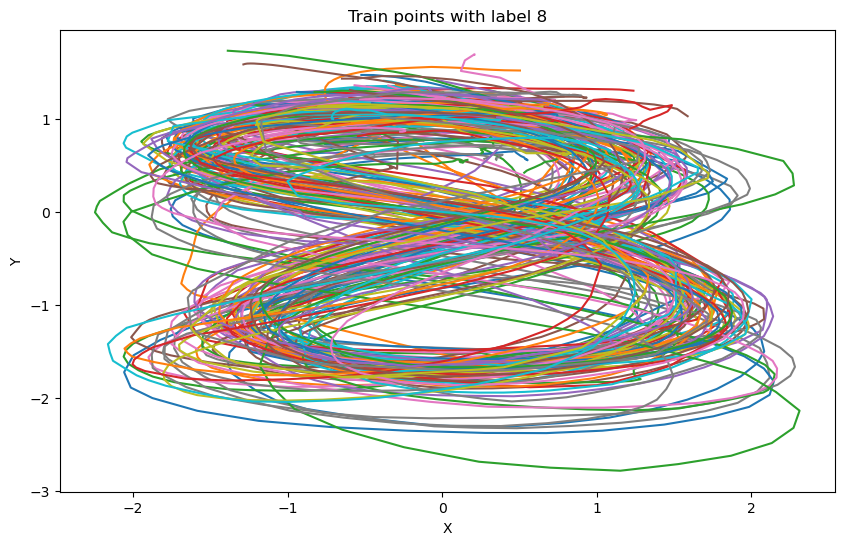

In [169]:
def preprocess_data( data, N_interp = 128 ):
    '''
    Preprocesses the data by interpolating to equal lengths and standardizing.
    
    Inputs:
    Data: list of numpy arrays, each array containing the measurement of a digit.
    N_interp: number of points to interpolate the variable-length data to.
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit after preprocessing.
    '''
    scaler = StandardScaler()
    
    for ii, sample in enumerate( data ):
        N_sample, dims = sample.shape
        
        tt = np.linspace(0, 1, N_sample, dtype=np.float32)
        tt_interp = np.linspace(0, 1, N_interp, dtype=np.float32)
        
        # First, interpolation (for each dimension separately)
        sample_interp = np.zeros( (N_interp, dims), dtype=np.float32 )
        for dim in range( dims ):          
            dim_interp = np.interp( tt_interp, tt, sample[:, dim] )
            sample_interp[:, dim] = dim_interp
            
        # Then standardization
        data[ii] = scaler.fit_transform( sample_interp ).transpose()
        # print( data[ii].shape )
        
    return data

data = preprocess_data( data )

X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.2, stratify = labels ) 

# Find six train points with label 8
label_8_indices = [i for i, label in enumerate(y_train) if label == 8][:100]

# Plot them in the same figure
plt.figure(figsize=(10, 6))
for idx in label_8_indices:
    plt.plot(X_train[idx][0, :], X_train[idx][1, :], label=f'Sample {idx}')
# plt.legend()
plt.title('Train points with label 8')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Create Dataset and Dataloader objects

In [170]:
class NumberDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.number_labels = labels

    def __len__(self):
        return len(self.number_labels)

    def __getitem__(self, idx):
        image = data[idx]
        label = self.number_labels[idx]
        return image, label
    
train_dataset = NumberDataset(X_train, y_train)
test_dataset = NumberDataset(X_test, y_test)

train_dataloader = DataLoader( train_dataset )
test_dataloader = DataLoader( test_dataset )

Building the network, defining loss and optimizer

In [171]:
class NumberNetwork( nn.Module ) :
    def __init__(self, input_size=3*128, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Input:1x128x3
        self.convolution_stack = nn.Sequential(
            nn.Conv1d( in_channels=3, out_channels=8, kernel_size=3, padding=1 ),  # Out:1x8x128
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                    # Out:1x8x64
            nn.Conv1d( in_channels=8, out_channels=16, kernel_size=3, padding=1 ), # Out:1x16x64
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                     # Out:1x16x32
            nn.Conv1d( in_channels=16, out_channels=32, kernel_size=3, padding=1 ), # Out:1x32x32
            nn.ReLU(),
            nn.MaxPool1d( kernel_size=2, stride=2 ),                     # Out:1x32x16
            nn.Conv1d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ),    # Out:1x64x16
            nn.ReLU(),
            nn.AvgPool1d( kernel_size=16, stride=1 ),   # Out:1x64x1
            nn.Flatten(),
            nn.Linear(64, 10),
        )
        
        # self.linear_stack = nn.Sequential(
        #     nn.Linear(input_size, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 36),
        #     nn.ReLU(),
        #     nn.Linear(36, 10),

        #     # nn.Dropout( p=0.25 )
        # )
 
    def forward(self, x):
        # x = self.flatten(x)
        # logits = self.linear_stack(x)
        logits = self.convolution_stack(x)
        return logits
    
# Get CPU or GPU 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")
    
model = NumberNetwork( input_size=3*128, num_classes=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=1e-3 )

Using cuda device


Defining train and test functions

In [172]:
def train( dataloader, model, loss_fn, optimizer ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0
    
    model.train()
    for ii, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute classification error
        train_class = model(X)
        loss = loss_fn( train_class, y ) 

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        correct += train_class.argmax( dim=1 )[0] == y.item()
        print( train_class, "\n,", y )
        total_loss += loss.item()

        # if ii % 100 == 0:
        #     loss, current = loss.item(), (ii + 1)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{N_data:>5d}]")
        
        # print( train_class.argmax( dim=1 )[0], y.item() )
        
    accuracy = correct / N_data
    
    return accuracy, total_loss
            
def test( dataloader, model, loss_fn ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_class = model(X)
            total_loss += loss_fn(test_class, y).item()
            correct += test_class.argmax( dim=1 )[0].item() == y.item()
       
    accuracy = correct/N_data
    
    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {total_loss:>8f} \n")
    
    return accuracy, total_loss

In [173]:
epochs = 100
train_accuracy = []
train_losses = []
test_accuracy = []
test_losses = []
for t in tqdm(range(epochs), desc="Training Progress", leave=True):
    train_acc, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_acc, test_loss = test(test_dataloader, model, loss_fn)
    
    if t % 10 == 0:
        print_str = f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        print( print_str )
    
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)
print("Training finished!")



Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 0.1053,  0.0596,  0.0409, -0.0668, -0.0792,  0.0964,  0.1139,  0.0138,
          0.1161, -0.0202]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0992,  0.0483,  0.0399, -0.0752, -0.0938,  0.0791,  0.1172,  0.0142,
          0.1202, -0.0273]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.1006,  0.0517,  0.0403, -0.0731, -0.0862,  0.0843,  0.1152,  0.0146,
          0.1177, -0.0241]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.1014,  0.0454,  0.0391, -0.0738, -0.0888,  0.0813,  0.1222,  0.0120,
          0.1205, -0.0302]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.1002,  0.0417,  0.0390, -0.0772, -0.0892,  0.0767,  0.1221,  0.0135,
          0.1206, -0.0310]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0981,  0.0498,  0.0380, -0.0765, -0.0967,  0.0791,  0.1164,  0.

Training Progress:   1%|          | 1/100 [00:01<02:40,  1.62s/it]

Test Error: 
 Accuracy: 9.5%, Avg loss: 460.822767 

tensor([[ 0.0964,  0.0569,  0.0401, -0.0529, -0.0656,  0.0912,  0.1036,  0.0168,
          0.1066, -0.0135]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0902,  0.0458,  0.0392, -0.0613, -0.0801,  0.0737,  0.1068,  0.0170,
          0.1107, -0.0208]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.0918,  0.0491,  0.0396, -0.0593, -0.0727,  0.0790,  0.1050,  0.0174,
          0.1083, -0.0175]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.0924,  0.0429,  0.0383, -0.0598, -0.0751,  0.0759,  0.1117,  0.0149,
          0.1110, -0.0236]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0911,  0.0393,  0.0381, -0.0630, -0.0753,  0.0714,  0.1115,  0.0164,
          0.1109, -0.0243]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0894,  0.0

Training Progress:   2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

tensor([[ 0.0920,  0.0556,  0.0406, -0.0405, -0.0499,  0.0859,  0.0905,  0.0220,
          0.0956, -0.0117]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([8], device='cuda:0')
tensor([[ 0.0855,  0.0529,  0.0368, -0.0469, -0.0643,  0.0759,  0.0912,  0.0213,
          0.0982, -0.0139]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([3], device='cuda:0')
tensor([[ 0.0851,  0.0513,  0.0369, -0.0444, -0.0647,  0.0753,  0.0915,  0.0213,
          0.0982, -0.0141]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0897,  0.0609,  0.0397, -0.0423, -0.0636,  0.0852,  0.0828,  0.0223,
          0.0984, -0.0093]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.0963,  0.0638,  0.0453, -0.0320, -0.0451,  0.0975,  0.0840,  0.0179,
          0.0920, -0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([8], device='cuda:0')
tensor([[ 0.1009,  0.0634,  0.0446, -0.0269, -0.0290,  0.1076,  0.0884,  0.

Training Progress:   3%|▎         | 3/100 [00:04<02:34,  1.60s/it]

tensor([[ 0.0821,  0.0473,  0.0358, -0.0381, -0.0481,  0.0717,  0.0888,  0.0246,
          0.0913, -0.0098]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([0], device='cuda:0')
tensor([[ 0.0893,  0.0602,  0.0423, -0.0235, -0.0296,  0.0935,  0.0777,  0.0200,
          0.0841, -0.0012]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0811,  0.0374,  0.0348, -0.0390, -0.0503,  0.0642,  0.0917,  0.0218,
          0.0924, -0.0155]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0879,  0.0575,  0.0396, -0.0274, -0.0399,  0.0872,  0.0837,  0.0152,
          0.0902, -0.0018]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([9], device='cuda:0')
tensor([[ 0.0904,  0.0615,  0.0444, -0.0213, -0.0256,  0.0967,  0.0778,  0.0188,
          0.0807, -0.0011]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([7], device='cuda:0')
tensor([[ 0.0788,  0.0468,  0.0351, -0.0398, -0.0573,  0.0652,  0.0860,  0.

Training Progress:   4%|▍         | 4/100 [00:06<02:35,  1.62s/it]

tensor([[ 0.0836,  0.0550,  0.0435, -0.0130, -0.0203,  0.0918,  0.0717,  0.0246,
          0.0757,  0.0012]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0790,  0.0484,  0.0400, -0.0225, -0.0370,  0.0745,  0.0751,  0.0249,
          0.0824, -0.0006]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([7], device='cuda:0')
tensor([[ 0.0837,  0.0560,  0.0419, -0.0136, -0.0178,  0.0902,  0.0729,  0.0241,
          0.0759,  0.0025]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([8], device='cuda:0')
tensor([[ 0.0813,  0.0584,  0.0414, -0.0142, -0.0249,  0.0916,  0.0731,  0.0257,
          0.0791,  0.0013]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([0], device='cuda:0')
tensor([[ 0.0839,  0.0523,  0.0408, -0.0201, -0.0301,  0.0830,  0.0741,  0.0252,
          0.0787, -0.0019]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([8], device='cuda:0')
tensor([[ 0.0733,  0.0458,  0.0351, -0.0284, -0.0506,  0.0637,  0.0775,  0.

Training Progress:   5%|▌         | 5/100 [00:08<02:34,  1.62s/it]

tensor([[ 0.0712,  0.0480,  0.0370, -0.0134, -0.0258,  0.0735,  0.0750,  0.0249,
          0.0796,  0.0065]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0647,  0.0379,  0.0365, -0.0211, -0.0397,  0.0558,  0.0778,  0.0243,
          0.0836, -0.0013]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.0666,  0.0409,  0.0369, -0.0194, -0.0326,  0.0615,  0.0764,  0.0251,
          0.0814,  0.0022]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.0664,  0.0349,  0.0353, -0.0193, -0.0345,  0.0583,  0.0821,  0.0226,
          0.0838, -0.0040]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0650,  0.0318,  0.0350, -0.0224, -0.0346,  0.0538,  0.0817,  0.0244,
          0.0834, -0.0043]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0644,  0.0395,  0.0349, -0.0231, -0.0431,  0.0556,  0.0780,  0.

Training Progress:   6%|▌         | 6/100 [00:09<02:34,  1.65s/it]

tensor([[ 0.0668,  0.0465,  0.0363, -0.0065, -0.0187,  0.0700,  0.0700,  0.0262,
          0.0749,  0.0101]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0602,  0.0365,  0.0360, -0.0140, -0.0323,  0.0521,  0.0727,  0.0254,
          0.0788,  0.0023]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.0622,  0.0395,  0.0364, -0.0124, -0.0253,  0.0580,  0.0714,  0.0263,
          0.0766,  0.0058]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.0618,  0.0335,  0.0347, -0.0121, -0.0271,  0.0547,  0.0769,  0.0238,
          0.0790, -0.0004]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0604,  0.0305,  0.0344, -0.0153, -0.0272,  0.0503,  0.0765,  0.0257,
          0.0785, -0.0006]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0600,  0.0381,  0.0344, -0.0161, -0.0358,  0.0520,  0.0730,  0.

Training Progress:   7%|▋         | 7/100 [00:11<02:34,  1.67s/it]

tensor([[ 0.0630,  0.0451,  0.0357, -0.0005, -0.0124,  0.0666,  0.0658,  0.0272,
          0.0708,  0.0134]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0563,  0.0354,  0.0355, -0.0078, -0.0259,  0.0488,  0.0683,  0.0263,
          0.0746,  0.0054]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([4], device='cuda:0')
tensor([[ 0.0584,  0.0382,  0.0359, -0.0063, -0.0189,  0.0547,  0.0670,  0.0272,
          0.0725,  0.0089]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.0578,  0.0323,  0.0341, -0.0059, -0.0206,  0.0514,  0.0724,  0.0248,
          0.0748,  0.0027]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0565,  0.0294,  0.0338, -0.0090, -0.0207,  0.0470,  0.0719,  0.0267,
          0.0743,  0.0026]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([1], device='cuda:0')
tensor([[ 0.0562,  0.0369,  0.0340, -0.0099, -0.0293,  0.0486,  0.0686,  0.

Training Progress:   7%|▋         | 7/100 [00:11<02:37,  1.70s/it]

tensor([[ 0.0715,  0.0454,  0.0438,  0.0044, -0.0005,  0.0799,  0.0707,  0.0294,
          0.0593,  0.0066]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([2], device='cuda:0')
tensor([[ 0.0678,  0.0413,  0.0423, -0.0040, -0.0108,  0.0683,  0.0741,  0.0332,
          0.0620,  0.0046]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([5], device='cuda:0')
tensor([[ 0.0601,  0.0302,  0.0377, -0.0093, -0.0243,  0.0529,  0.0803,  0.0298,
          0.0680, -0.0053]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([0], device='cuda:0')
tensor([[0.0746, 0.0448, 0.0422, 0.0054, 0.0025, 0.0802, 0.0746, 0.0296, 0.0563,
         0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>) 
, tensor([3], device='cuda:0')


KeyboardInterrupt: 